# DA example after initaliastion

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

In [2]:
from importlib import reload

GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
gpu_stream = cuda.Stream()

Utils

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [7]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm", title=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.suptitle(title, y=0.85)

    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [8]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [9]:
def imshowSim(sim, eta_vlim=0.05, huv_lim=2.0):
    eta, hu, hv = sim.download(interior_domain_only=False)
    return imshow3(np.array([eta, hu, hv]), eta_vlim=eta_vlim, huv_vlim=huv_lim)

### Perturbing initial conditions

In [10]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [11]:
ls = [6, 7, 8, 9, 10]

In [12]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [13]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.05,
}

In [14]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0025,
}


### Ensemble

In [15]:
read_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevels/Basin/2023-05-05T14_03_12"

vars = np.load(read_path+"/vars_43200.npy")
diff_vars = np.load(read_path+"/diff_vars_43200.npy")

In [16]:
from utils.BasinAnalysis import *
analysis = Analysis(ls, vars, diff_vars, args_list)

In [17]:
ML_Nes = analysis.optimal_Ne(tau=1.25e-4)#5e-5)
ML_Nes

array([1534,  198,   39,    7,    3], dtype=int32)

### Ensemble

In [18]:
from utils.BasinEnsembleInit import *

In [19]:
ML_ensemble = initMLensemble(ML_Nes, args_list, make_init_steady_state, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1
2
3
4


In [20]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [21]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [22]:
prior_ensemble = copy.deepcopy(MLOceanEnsemble.download())

### Statistics

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

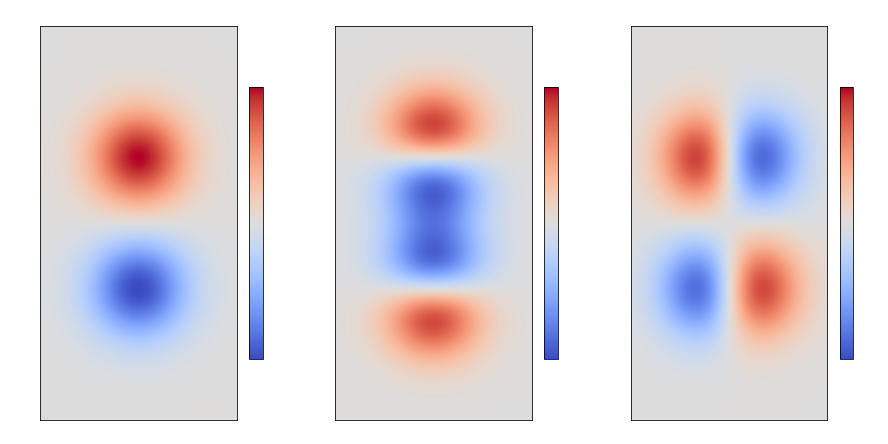

In [23]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

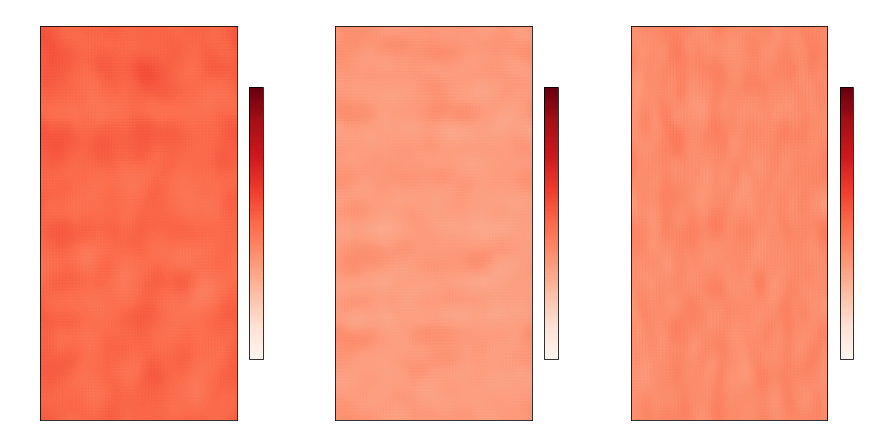

In [24]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=1e-3, huv_lim=5)

### Truth

In [25]:
from utils.BasinInit import *

In [26]:
data_args = make_init_steady_state(args_list[-1])

In [27]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args)
mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
mekl.perturbSim(truth)

In [28]:
Hx, Hy = 500, 1000

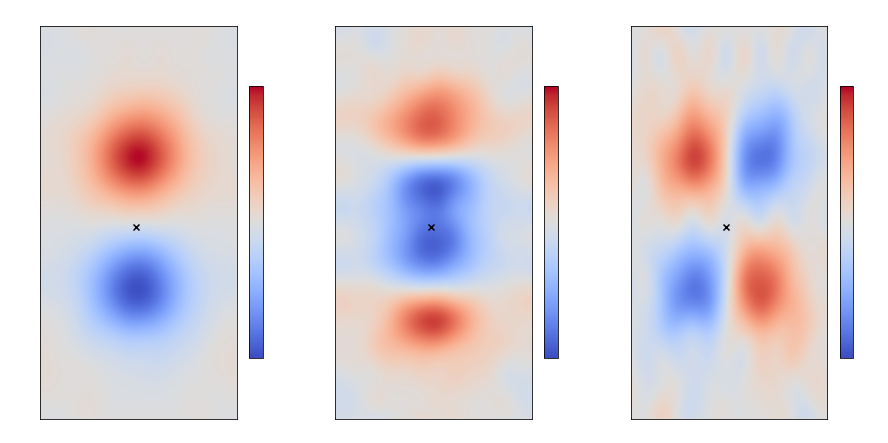

In [29]:
fig, axs = imshowSim(truth, eta_vlim=1, huv_lim=25)

for i in range(3):
    axs[i].scatter(Hx, Hy, marker="x", c="black")

In [30]:
R = [5e-3, 5e-1, 5e-1]

In [31]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

print([true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]])
print(obs)

[-0.074095555, -20.432241, -1.5040269]
[ -0.07291387 -21.05331477  -1.98560381]


### Conditioning after initial noise

In [32]:
MLOceanEnsemble.upload(prior_ensemble)
MLOceanEnsemble.MSE(truth, [[Hx,Hy]])

[array([6.7814987e-04, 1.8834615e+00, 3.6177630e+00], dtype=float32)]

In [33]:
from gpuocean.dataassimilation import MLEnKFOcean

In [34]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

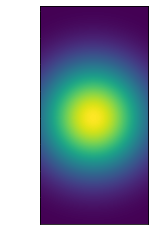

In [35]:
r = 5e4
plt.imshow( MLEnKF.GCweights(MLEnKF.X[0,Hx], MLEnKF.Y[Hy,0], r) )

In [36]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 5*1e7, obs_var=slice(1,3), relax_factor = 0.5, min_localisation_level=0)

In [37]:
MLOceanEnsemble.MSE(truth, [[Hx,Hy]])

[array([6.7931711e-04, 7.2102928e-01, 4.5029622e-01], dtype=float32)]

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

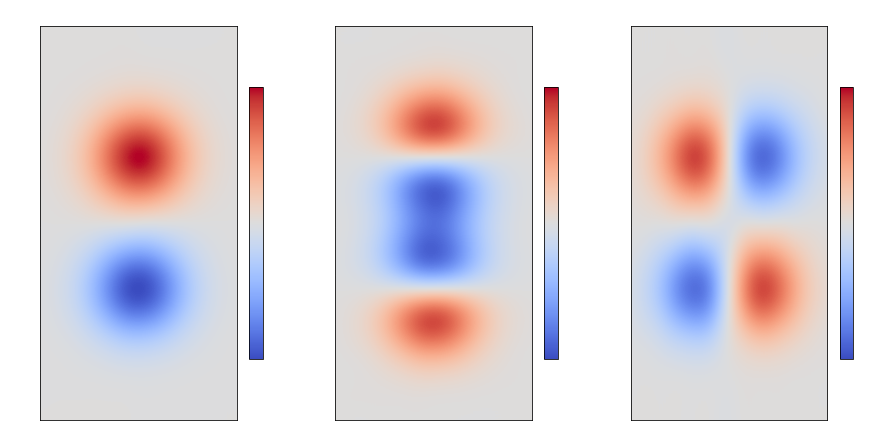

In [38]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

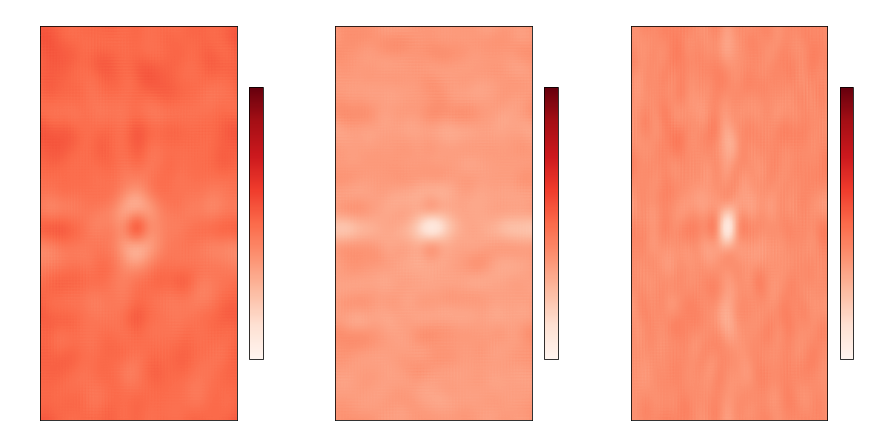

In [39]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=1e-3, huv_lim=5)

In [40]:
freq = 50
Hxs = np.arange( 512, 1024, freq)
Hys = np.arange(1024, 2048, 2*freq)

In [41]:
MLOceanEnsemble.rank(truth, [z for z in zip(Hxs, Hys)])

[array([0.73387912, 0.92860812, 0.48152977]),
 array([0.38959346, 0.95485494, 0.44609063]),
 array([0.02672751, 0.24556517, 0.17407451]),
 array([0.04434172, 0.10738414, 0.67633308]),
 array([0.49621659, 0.11240172, 0.57466357]),
 array([0.45315607, 0.10846404, 0.09577522]),
 array([0.33842429, 0.29985645, 0.04334742]),
 array([0.346088  , 0.18268737, 0.3828375 ]),
 array([0.35250813, 0.75095902, 0.5747313 ]),
 array([0.19816812, 0.66421714, 0.21131787]),
 array([0.10039113, 0.18449159, 0.40008955])]

### Data Assimilation Step

In [42]:
truth.setKLModelError(**sim_model_error_basis_args)
truth.model_time_step = 60.0

truth.dataAssimilationStep(300)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

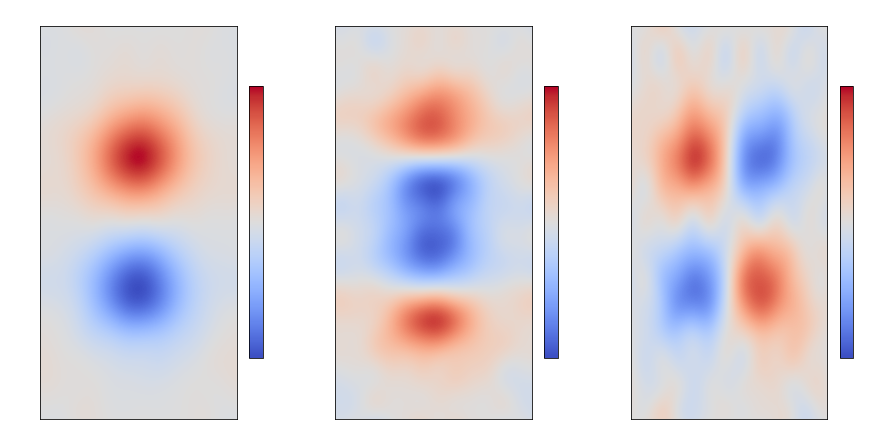

In [43]:
imshowSim(truth, eta_vlim=1, huv_lim=25)

In [44]:
MLOceanEnsemble.stepToObservation(300)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

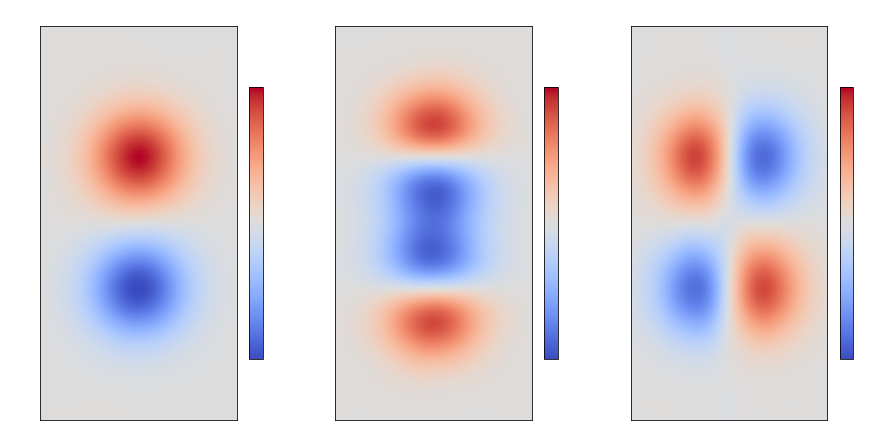

In [45]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)